# **Group Assignment** - Bike Sharing

- `instant`: record index
- `dteday` : date
- `season` : season (1:springer, 2:summer, 3:fall, 4:winter)
- `yr` : year (0: 2011, 1:2012)
- `mnth` : month ( 1 to 12)
- `hr` : hour (0 to 23)
- `holiday` : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- `weekday` : day of the week
- `workingday` : if day is neither weekend nor holiday is 1, otherwise is 0.
+ `weathersit` : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp` : Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

## PART I: Exploratory Data Analysis

# Creating decoders

In [20]:
def code_to_season(code):
    if code == 1:
        return "Spring"
    elif code == 2:
        return "Summer"
    elif code == 3:
        return "Fall"
    else:
        return "Winter"

def code_to_weather(code):
    if code == 1:
        return "Clear"
    elif code == 2:
        return "Mist"
    elif code == 3:
        return "Light Snow"
    else:
        return "Heavy Rain"

# Import Data

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

In [22]:
data = pd.read_csv("bike-sharing_hourly.csv")
data

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


# Ensuring data quality (correctness, consistency, missing values, outliers...).

In [23]:
bike_data = data.copy()

In [24]:
data_types = bike_data.dtypes
data_types

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [25]:
duplicate_rows = bike_data.duplicated().sum()
duplicate_rows

0

In [26]:
missing_values = bike_data.isnull().sum()
missing_values

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [27]:
summary_statistics = bike_data.describe()
summary_statistics

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [28]:
bike_data['dteday'] = pd.to_datetime(bike_data['dteday'])
bike_data['dteday'].dtype

dtype('<M8[ns]')

# Plotting box plot for continuos variables

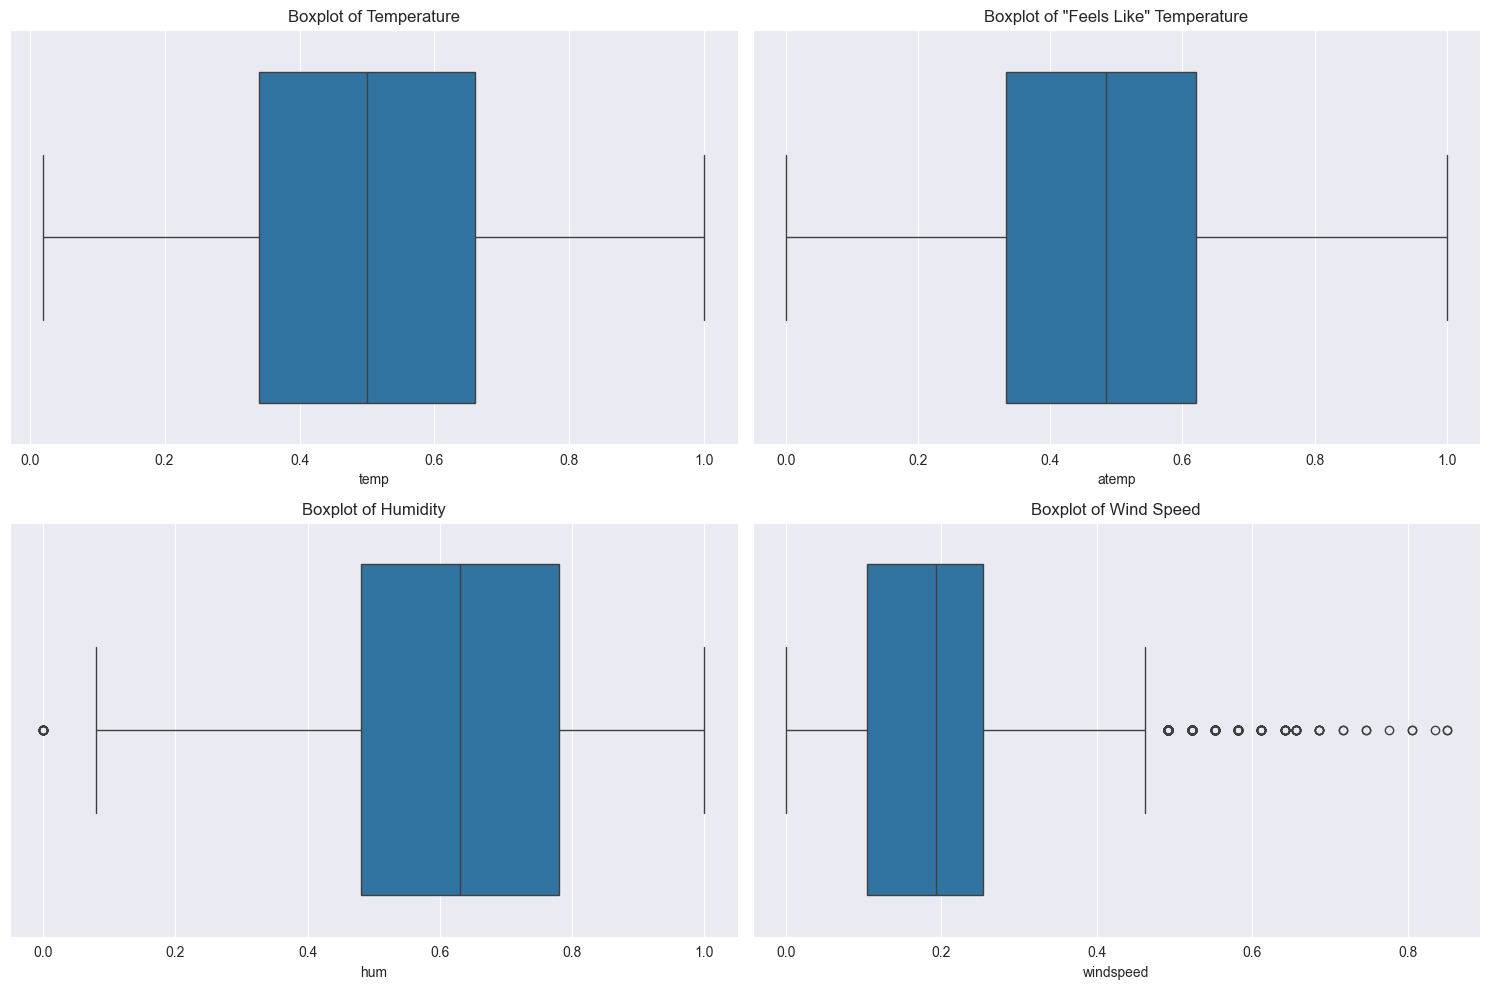

In [29]:
# Plotting boxplots for continuous variables
plt.figure(figsize=(15, 10))

# Subplot for 'temp'
plt.subplot(2, 2, 1)
sns.boxplot(x=bike_data['temp'])
plt.title('Boxplot of Temperature')

# Subplot for 'atemp'
plt.subplot(2, 2, 2)
sns.boxplot(x=bike_data['atemp'])
plt.title('Boxplot of "Feels Like" Temperature')

# Subplot for 'hum'
plt.subplot(2, 2, 3)
sns.boxplot(x=bike_data['hum'])
plt.title('Boxplot of Humidity')

# Subplot for 'windspeed'
plt.subplot(2, 2, 4)
sns.boxplot(x=bike_data['windspeed'])
plt.title('Boxplot of Wind Speed')

plt.tight_layout()
plt.show()

# hum -> Some ceros, maybe an error of the sensor
# windspeed -> Several outliers ; RobustScaler is recommended

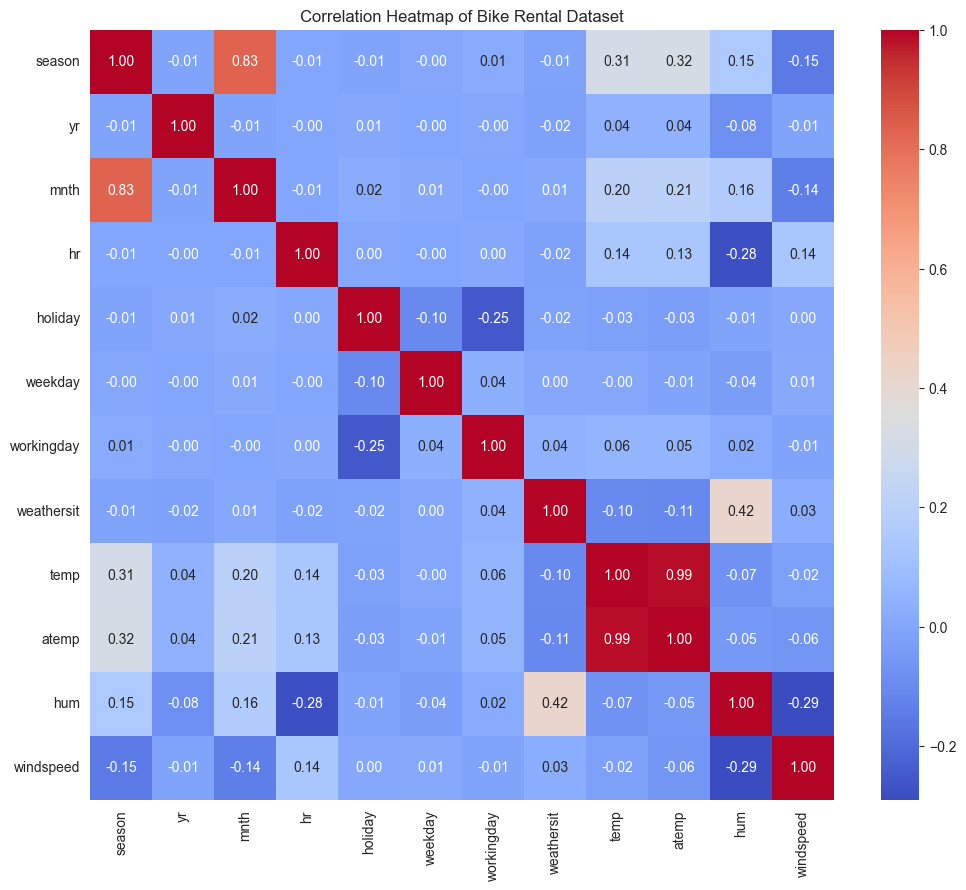

In [30]:
# Plot data without enconding
data_corr = pd.read_csv("bike-sharing_hourly.csv").drop(columns=["instant","dteday", "casual", "registered", "cnt"])
plt.figure(figsize=(12, 10))
corr_matrix = data_corr.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Bike Rental Dataset')
plt.show()

# High correlations
# season --> mnth
# temp --> atemp

# Giving insights on what seems relevant for prediction and what does not.
## Notes
- No missing values
- hum -> Some ceros, maybe an error of the sensor
- windspeed -> Several outliers 
- High correlations
-- season <--> mnth
-- temp <--> atemp
## Decisions
-- RobustScaler is recommended because there are outliers
-- Use season instead mnth and year
-- Use weathersit instead of numerical weather values. The first summarize everything.

# Decoding variables

In [31]:
bike_data.season = bike_data.season.apply(code_to_season)
bike_data.weathersit = bike_data.weathersit.apply(code_to_weather)
bike_data.to_csv("bike_db.csv", index=False)
bike_data

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,Spring,0,1,0,0,6,0,Clear,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,Spring,0,1,1,0,6,0,Clear,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,Spring,0,1,2,0,6,0,Clear,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,Spring,0,1,3,0,6,0,Clear,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,Spring,0,1,4,0,6,0,Clear,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,Spring,1,12,19,0,1,1,Mist,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,Spring,1,12,20,0,1,1,Mist,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,Spring,1,12,21,0,1,1,Clear,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,Spring,1,12,22,0,1,1,Clear,0.26,0.2727,0.56,0.1343,13,48,61



# Plotting clear and meaningful figures.

In [32]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=bike_data.index, y=bike_data["cnt"], mode="lines"))
fig.update_layout(title="Bike Rentals Over Time", xaxis_title="Date", yaxis_title="Total Rentals")
fig.show()

fig = px.box(bike_data, x="hr", y="cnt")
fig.update_layout(title="Bike Rentals by Hour of the Day", xaxis_title="Hour of the Day",
                          yaxis_title="Total Rentals")
fig.show()

fig_weather = go.Figure()
fig_weather.add_trace(go.Box(x=bike_data["weathersit"], y=bike_data["cnt"]))
fig_weather.update_layout(title="Bike Rentals by Weather Situation", xaxis_title="Weather Situation", yaxis_title="Total Rentals")
fig_weather.show()

fig_season = go.Figure()
fig_season.add_trace(go.Box(x=bike_data["season"], y=bike_data["cnt"]))
fig_season.update_layout(title="Bike Rentals by Season", xaxis_title="Season", yaxis_title="Total Rentals")
fig_season.show()

In [33]:
# Grouping the data by 'hr' and 'weathersit' and calculating the sum of 'cnt'
grouped_data = bike_data.groupby(['hr', 'weathersit'])['cnt'].sum().reset_index()
# Pivot the data to get 'weathersit' as columns and 'hr' as rows
pivot_data = grouped_data.pivot(index='hr', columns='weathersit', values='cnt').fillna(0)
# Create a stacked bar chart
fig = px.bar(pivot_data, 
             x=pivot_data.index, 
             y=pivot_data.columns, 
             labels={'value': 'Total Rentals'}, 
             title="Bike Rentals by Hour and Weather Situation")
# Show the plot
fig.show()

In [34]:
# Grouping the data by 'hr' and 'season' and calculating the sum of 'cnt'
grouped_data = bike_data.groupby(['hr', 'season'])['cnt'].sum().reset_index()

# Pivot the data to get 'season' as columns and 'hr' as rows
pivot_data = grouped_data.pivot(index='hr', columns='season', values='cnt').fillna(0)

# Create a stacked bar chart
fig = px.bar(pivot_data, 
             x=pivot_data.index, 
             y=pivot_data.columns, 
             labels={'value': 'Total Rentals'}, 
             title="Bike Rentals by Hour and Season")

# Show the plot
fig.show()

## PART II: Prediction Model

## PART III: Streamlit dashboard

In [5]:
### This part goes in a separate script ###